In [ ]:
!git clone https://github.com/deepseek-ai/Janus.git


Cloning into 'Janus'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 35 (delta 4), reused 35 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 955.66 KiB | 6.73 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
%cd Janus
!pip install -e .
!pip install flash-attn

/content/Janus
Obtaining file:///content/Janus
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for janus (pyproject.toml) ... done
  Created wheel for janus: filename=janus-1.0.0-0.editable-py3-none-any.whl size=13213 sha256=6549905c4ca7d80ffe93b29502638be9402c9b6e9ad02be1fe7c1de49807f601
  Stored in directory: /tmp/pip-ephem-wheel-cache-3bjwhhza/wheels/db/43/fb/dfa5a5a63d3fcf28c66693ac6be0a596a4e95ee0b525246235
Successfully built janus
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=187309225 sha256=237ef9c6157db394e1ddde4ba609a21ebb98382377a27041edc09318801a6f24
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9

In [ ]:

import torch
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

# specify the path to the model
model_path = "deepseek-ai/Janus-1.3B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

conversation = [
    {
        "role": "User",
        "content": "<image_placeholder>\nConvert the formula into latex code.",
        "images": ["images/equation.png"],
    },
    {"role": "Assistant", "content": ""},
]

# load images and prepare for inputs
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

# # run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# # run the model to get the response
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)


Python version is above 3.10, patching the collections module.


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/image_processing_auto.py:513: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/106k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.72M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/97.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


processor_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: sft_format, ignore_id, add_special_token, mask_prompt, num_image_tokens, image_tag. 


Add image tag = <image_placeholder> to the tokenizer


config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in LlamaForCausalLM is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `torch_dtype` argument. Example: `model = AutoModel.from_pretrained("openai/whisper-tiny", attn_implementation="flash_attention_2", torch_dtype=torch.float16)`
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in LlamaModel is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `torch_dtype` argument. Example: `model = AutoModel.from_pretrained("openai/whisper-tiny", attn_implementation="flash_attention_2", torch_dtype=torch.float16)`


You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

User: <image_placeholder>
Convert the formula into latex code.

Assistant: Sure, here is the LaTeX code for the formula:

\[ A_n = a_0 \left[ 1 + \frac{3}{4} \sum_{k=1}^{n} \left( \frac{4}{9} \right)^k \right] \]


In [1]:
!git clone https://github.com/deepseek-ai/Janus.git

Cloning into 'Janus'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 115 (delta 23), reused 22 (delta 14), pack-reused 74 (from 1)
Receiving objects: 100% (115/115), 7.16 MiB | 17.88 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [2]:
%cd Janus

/content/Janus


In [3]:
!pip install -e .

Obtaining file:///content/Janus
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for janus (pyproject.toml) ... done
  Created wheel for janus: filename=janus-1.0.0-0.editable-py3-none-any.whl size=15926 sha256=547723b0d856a4da5a6bec45819731f66a2e262d9cf4acca4b58fae55793d358
  Stored in directory: /tmp/pip-ephem-wheel-cache-3a5w0zco/wheels/04/ee/d6/76a460ef4080a263aa86cc3fdbb1c5bb29f559fbd8155d1c83
Successfully built janus


In [4]:
!pip install flash-attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 37.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.7.3-cp311-cp311-linux_x86_64.whl size=191363917 sha256=b1243e9b86687348a5ab03a073abacdf8e3d5e9e4b7e5326a183f47348c5dfba
  Stored in directory: /root/.cache/pip/wheels/d0/a3/f9/48d2706cb2eac05ec0dc144bf6954fe47bb3c2cd0de280765e
Successfully built flash-attn


aشغال

In [5]:
import torch
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

# specify the path to the model
model_path = "deepseek-ai/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

# تحديد مسار الصورة والسؤال
image_path = "/content/Janus/images/equation.png"
question = "What is in the image?"

# بناء قائمة المحادثة
conversation = [
    {
        "role": "<|User|>",  # تم تغيير دور المستخدم إلى "<|User|>"
        "content": f"<image_placeholder>\n{question}",
        "images": [image_path], # تم وضع مسار الصورة في قائمة
    },
    {"role": "<|Assistant|>", "content": ""},
]

# تحميل الصور وإعداد المدخلات
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

# تشغيل مشفر الصور للحصول على الـ embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# تشغيل النموذج للحصول على الاستجابة
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)

# فك تشفير الاستجابة
answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)

Python version is above 3.10, patching the collections module.


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/image_processing_auto.py:524: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.72M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


processor_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: mask_prompt, num_image_tokens, ignore_id, image_tag, sft_format, add_special_token. 


config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

<|User|>: <image_placeholder>
What is in the image?

<|Assistant|>: The image shows a mathematical expression involving a summation and a product. The expression is:

\[
A_n = \left| a_0 \right| \left| 1 + \frac{3}{4} \sum_{k=1}^{n} \begin{pmatrix} 4 \\ 9 \end{pmatrix}^k \right|
\]

This is a representation of the absolute value of the sum of a geometric series. The geometric series is given by:

\[
a_n = 1 + 3 + 4 + \cdots + 4^n
\]

The expression evaluates to:

\[
A_n = \left| a_0 \right| \left| 1 + \frac{3}{4} \left( \begin{pmatrix} 4 \\ 9 \end{pmatrix}^n \right) \right|
\]

This is the result of the absolute value of the sum of a geometric series, multiplied by the absolute value of the product of the vector and the geometric series.


In [1]:
import torch
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

# specify the path to the model
model_path = "deepseek-ai/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

# تحديد مسار الصورة والسؤال
image_path = "/content/demo (1).jpeg"
question = "What is in the image?"

# بناء قائمة المحادثة
conversation = [
    {
        "role": "<|User|>",  # تم تغيير دور المستخدم إلى "<|User|>"
        "content": f"<image_placeholder>\n{question}",
        "images": [image_path], # تم وضع مسار الصورة في قائمة
    },
    {"role": "<|Assistant|>", "content": ""},
]

# تحميل الصور وإعداد المدخلات
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

# تشغيل مشفر الصور للحصول على الـ embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# تشغيل النموذج للحصول على الاستجابة
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)

# فك تشفير الاستجابة
answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)

Python version is above 3.10, patching the collections module.


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/image_processing_auto.py:524: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) b

You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

<|User|>: <image_placeholder>
What is in the image?

<|Assistant|>: The image shows a person sitting on a sandy beach with a dog. The person is wearing a plaid shirt and is interacting with the dog, who is sitting and reaching up with its paw. The ocean and the horizon are visible in the background.


In [2]:
import torch
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

# specify the path to the model
model_path = "deepseek-ai/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

# تحديد مسار الصورة والسؤال
image_path = "/content/R.jpg"
question = "What is in the image?"

# بناء قائمة المحادثة
conversation = [
    {
        "role": "<|User|>",  # تم تغيير دور المستخدم إلى "<|User|>"
        "content": f"<image_placeholder>\n{question}",
        "images": [image_path], # تم وضع مسار الصورة في قائمة
    },
    {"role": "<|Assistant|>", "content": ""},
]

# تحميل الصور وإعداد المدخلات
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

# تشغيل مشفر الصور للحصول على الـ embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# تشغيل النموذج للحصول على الاستجابة
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)

# فك تشفير الاستجابة
answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)

Some kwargs in processor config are unused and will not have any effect: ignore_id, image_tag, sft_format, num_image_tokens, add_special_token, mask_prompt. 


You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

<|User|>: <image_placeholder>
What is in the image?

<|Assistant|>: The image shows three adorable puppies sitting on a wooden surface, possibly a crate or a bench. They appear to be enjoying themselves, with one puppy making a playful face and sticking its tongue out. There are also some flowers in the bottom left corner of the image.


In [1]:
import os
import PIL.Image
import torch
import numpy as np
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor


# specify the path to the model
model_path = "deepseek-ai/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

conversation = [
    {
        "role": "<|User|>",
        "content": "A stunning princess from kabul in red, white traditional clothing, blue eyes, brown hair",
    },
    {"role": "<|Assistant|>", "content": ""},
]

sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt="",
)
prompt = sft_format + vl_chat_processor.image_start_tag


@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 16,
    cfg_weight: float = 5,
    image_token_num_per_image: int = 576,
    img_size: int = 384,
    patch_size: int = 16,
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    tokens = torch.zeros((parallel_size*2, len(input_ids)), dtype=torch.int).cuda()
    for i in range(parallel_size*2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).cuda()

    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state

        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]

        logits = logit_uncond + cfg_weight * (logit_cond-logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)


    dec = mmgpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int), shape=[parallel_size, 8, img_size//patch_size, img_size//patch_size])
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join('generated_samples', "img_{}.jpg".format(i))
        PIL.Image.fromarray(visual_img[i]).save(save_path)


generate(
    vl_gpt,
    vl_chat_processor,
    prompt,
)

Python version is above 3.10, patching the collections module.


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/image_processing_auto.py:524: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) b

OutOfMemoryError: CUDA out of memory. Tried to allocate 134.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 111.06 MiB is free. Process 44599 has 14.64 GiB memory in use. Of the allocated memory 10.39 GiB is allocated by PyTorch, and 4.13 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

شغال انشاء صور

In [1]:
import os
import PIL.Image
import torch
import numpy as np
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor


# specify the path to the model
model_path = "deepseek-ai/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

conversation = [
    {
        "role": "<|User|>",
        "content": "A stunning princess from kabul in red, white traditional clothing, blue eyes, brown hair",
    },
    {"role": "<|Assistant|>", "content": ""},
]

sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt="",
)
prompt = sft_format + vl_chat_processor.image_start_tag


@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 16,
    cfg_weight: float = 5,
    image_token_num_per_image: int = 576,
    img_size: int = 384,
    patch_size: int = 16,
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    tokens = torch.zeros((parallel_size*2, len(input_ids)), dtype=torch.int).cuda()
    for i in range(parallel_size*2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).cuda()

    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state

        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]

        logits = logit_uncond + cfg_weight * (logit_cond-logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)


    dec = mmgpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int), shape=[parallel_size, 8, img_size//patch_size, img_size//patch_size])
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join('generated_samples', "img_{}.jpg".format(i))
        PIL.Image.fromarray(visual_img[i]).save(save_path)


generate(
        vl_gpt,
        vl_chat_processor,
        prompt,
        parallel_size=8  # Reduced from 16 to 8
    )

Python version is above 3.10, patching the collections module.


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/image_processing_auto.py:524: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) b

In [ ]:
/content/generated_samples
/content/generated_samples/img_0.jpg

/content/generated_samples/img_1.jpg

شغال عرض الصور

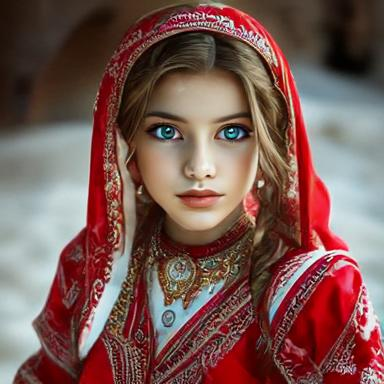

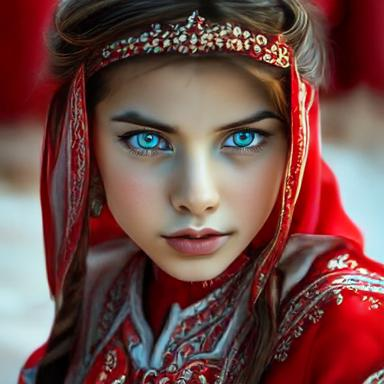

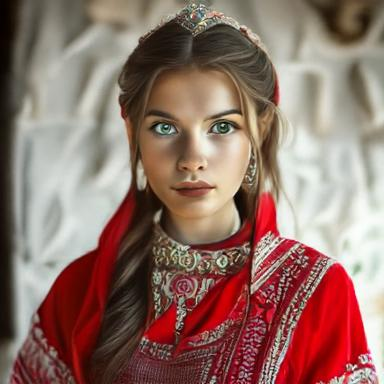

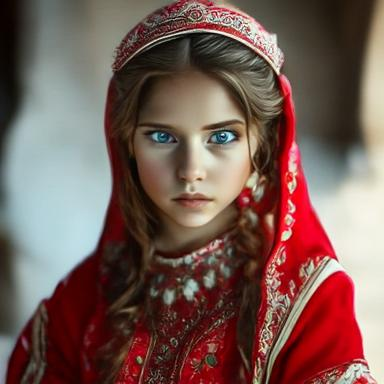

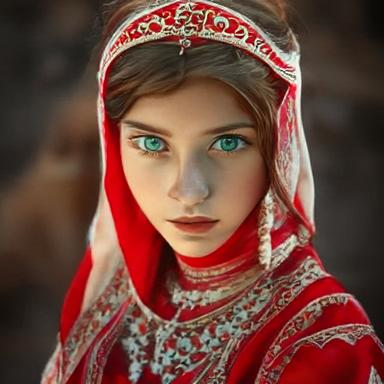

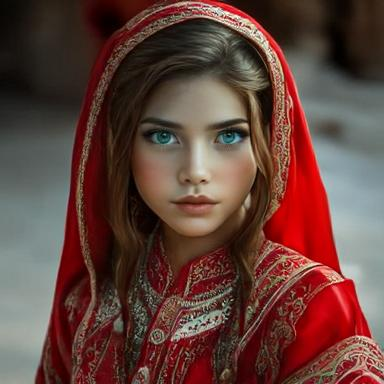

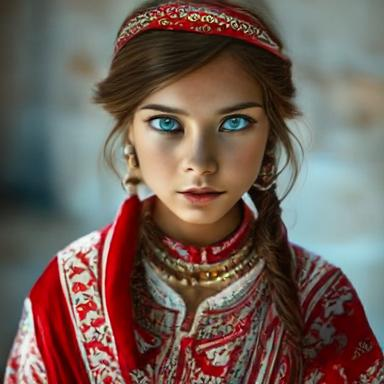

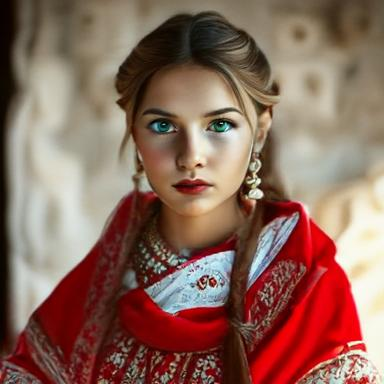

In [1]:
import os
import PIL.Image
from IPython.display import display

# Path to the directory containing the images
image_dir = 'generated_samples'

# Iterate through the images in the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):  # Filter for JPG images
        image_path = os.path.join(image_dir, filename)
        image = PIL.Image.open(image_path)
        display(image)  # Display the image in the notebook

In [2]:
import os
import PIL.Image
import torch
import numpy as np
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor


# specify the path to the model
model_path = "deepseek-ai/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

conversation = [
    {
        "role": "<|User|>",
        "content": "A stunning princess from kabul in red, white traditional clothing, blue eyes, brown hair",
    },
    {"role": "<|Assistant|>", "content": ""},
]

sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt="",
)
prompt = sft_format + vl_chat_processor.image_start_tag


@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 16,
    cfg_weight: float = 5,
    image_token_num_per_image: int = 576,
    img_size: int = 384,
    patch_size: int = 16,
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    tokens = torch.zeros((parallel_size*2, len(input_ids)), dtype=torch.int).cuda()
    for i in range(parallel_size*2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).cuda()

    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state

        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]

        logits = logit_uncond + cfg_weight * (logit_cond-logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)


    dec = mmgpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int), shape=[parallel_size, 8, img_size//patch_size, img_size//patch_size])
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join('generated_samples', "img_{}.jpg".format(i))
        PIL.Image.fromarray(visual_img[i]).save(save_path)


generate(
        vl_gpt,
        vl_chat_processor,
        prompt,
        parallel_size=1  # Reduced from 16 to 8
    )

Python version is above 3.10, patching the collections module.


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/image_processing_auto.py:524: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) b

In [3]:
!rm -rf /content/generated_samples

parallel_size: يتحكم هذا المعامل في عدد الصور التي يتم إنشاؤها بالتوازي. في الكود الخاص بك، يتم تعيينه على 1، مما يعني أنه يتم إنشاء صورة واحدة فقط في كل مرة. سيؤدي زيادة هذه القيمة إلى إنشاء المزيد من الصور في نفس الوقت.

image_token_num_per_image: يحدد هذا عدد الرموز المستخدمة لتمثيل كل صورة أثناء التوليد. تؤدي القيمة الأعلى عمومًا إلى صور أكثر تفصيلاً ولكنها تزيد أيضًا من وقت التوليد.

img_size: يحدد هذا دقة الصور المولدة. تم تعيينه حاليًا على 384، مما يؤدي إلى صور بحجم 384 × 384 بكسل. يمكنك تعديل هذه القيمة لتغيير دقة الصورة.

patch_size: يحدد هذا المعامل حجم الرقع المستخدمة في عملية إنشاء الصورة. عادةً ما يتم الاحتفاظ به عند 16 ولا يلزم تغييره بشكل متكرر.

مسار الإخراج: يتم حفظ الصور المولدة في دليل يسمى "generated_samples". يتم إنشاء هذا الدليل تلقائيًا إذا لم يكن موجودًا. يتم حفظ كل صورة بصيغة "img_{}.jpg"، حيث {} هو فهرس الصورة.

ضبط إعدادات الصورة

In [ ]:
import os
import PIL.Image
import torch
import numpy as np
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor


# specify the path to the model
model_path = "deepseek-ai/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

conversation = [
    {
        "role": "<|User|>",
        "content": "dog with cat",
    },
    {"role": "<|Assistant|>", "content": ""},
]

sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt="",
)
prompt = sft_format + vl_chat_processor.image_start_tag


@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 1,
    cfg_weight: float = 5,
    image_token_num_per_image: int = 576,  # Reduced for a smaller image
    img_size: int = 1024,  # This should match the intended image size (ignored now)
    patch_size: int = 16, # This should match the intended image size (ignored now)
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    tokens = torch.zeros((parallel_size * 2, len(input_ids)), dtype=torch.int).cuda()
    for i in range(parallel_size * 2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).cuda()

    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state

        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]

        logits = logit_uncond + cfg_weight * (logit_cond - logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)

    # Calculate side_length for dynamic shape:
    side_length = int((image_token_num_per_image / 8)**0.5)

    dec = mmgpt.gen_vision_model.decode_code(
        generated_tokens.to(dtype=torch.int),
        shape=[parallel_size, 8, side_length, side_length]
    )

    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, side_length * patch_size, side_length * patch_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join('generated_samples', "img_{}.jpg".format(i))
        PIL.Image.fromarray(visual_img[i]).save(save_path)


generate(
    vl_gpt,
    vl_chat_processor,
    prompt,
    parallel_size=1,
)

التعديلات الرئيسية:
parallel_size=1: تم تغيير هذه القيمة إلى 1 لإنشاء صورة واحدة فقط.

img_size=768: تم زيادة حجم الصورة إلى 768 بكسل لتحسين الدقة.

ملاحظة:
تأكد من أن الذاكرة المتاحة على GPU كافية لمعالجة الصور ذات الدقة العالية. إذا واجهت مشاكل في الذاكرة، يمكنك تقليل img_size إلى 512 أو 640 بدلاً من 768.

إذا كنت ترغب في زيادة دقة الصورة أكثر، يمكنك تجربة img_size=1024، ولكن تأكد من أن الجهاز الخاص بك

In [2]:
import os
import PIL.Image
import torch
import numpy as np
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor


# Specify the path to the model
model_path = "deepseek-ai/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

# Load the model
vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

# Define the conversation
conversation = [
    {
        "role": "<|User|>",
        "content": "A stunning princess from kabul in red, white traditional clothing, blue eyes, brown hair",
    },
    {"role": "<|Assistant|>", "content": ""},
]

# Apply the SFT template for multi-turn prompts
sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt="",
)
prompt = sft_format + vl_chat_processor.image_start_tag


@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 1,  # Generate only one image
    cfg_weight: float = 5,
    image_token_num_per_image: int = 576,  # Number of tokens per image
    img_size: int = 768,  # Increased image size to 768x768
    patch_size: int = 16,
):
    # Tokenize the input prompt
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    # Prepare input tokens
    tokens = torch.zeros((parallel_size * 2, len(input_ids)), dtype=torch.int).cuda()
    for i in range(parallel_size * 2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    # Get input embeddings
    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    # Initialize generated tokens
    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).cuda()

    # Generate tokens step by step
    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(
            inputs_embeds=inputs_embeds,
            use_cache=True,
            past_key_values=outputs.past_key_values if i != 0 else None,
        )
        hidden_states = outputs.last_hidden_state

        # Calculate logits
        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]

        # Apply CFG (Classifier-Free Guidance)
        logits = logit_uncond + cfg_weight * (logit_cond - logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        # Sample the next token
        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        # Prepare input embeddings for the next step
        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)

    # Decode the generated tokens into an image
    dec = mmgpt.gen_vision_model.decode_code(
        generated_tokens.to(dtype=torch.int),
        shape=[parallel_size, 8, img_size // patch_size, img_size // patch_size],  # Adjusted shape
    )
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    # Normalize and convert to uint8
    dec = np.clip((dec + 1) / 2 * 255, 0, 255).astype(np.uint8)

    # Save the generated image
    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join('generated_samples', "img_{}.jpg".format(i))
        PIL.Image.fromarray(dec[i]).save(save_path)
        print(f"Image saved at: {save_path}")


# Generate the image
generate(
    vl_gpt,
    vl_chat_processor,
    prompt,
    parallel_size=1,  # Generate only one image
    img_size=768,  # Increased image size to 768x768
)

Python version is above 3.10, patching the collections module.


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/image_processing_auto.py:524: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) b

RuntimeError: shape '[1, 48, 48, 8]' is invalid for input of size 4608

In [1]:
@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 1,  # Reduced to 1 for a single image
    cfg_weight: float = 5,
    image_token_num_per_image: int = 576,  # Keep this as is
    img_size: int = 768,  # Increased image size to 768
    patch_size: int = 16,
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    tokens = torch.zeros((parallel_size*2, len(input_ids)), dtype=torch.int).cuda()
    for i in range(parallel_size*2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).cuda()

    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state

        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]

        logits = logit_uncond + cfg_weight * (logit_cond-logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)

    # Adjust the shape to match image_token_num_per_image
    dec = mmgpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int), shape=[parallel_size, 8, 24, 24])  # Adjusted shape
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join('generated_samples', "img_{}.jpg".format(i))
        PIL.Image.fromarray(visual_img[i]).save(save_path)


generate(
        vl_gpt,
        vl_chat_processor,
        prompt,
        parallel_size=1,  # Reduced to 1 for a single image
        img_size=768  # Increased image size to 768
    )

NameError: name 'torch' is not defined

In [1]:
import os
import PIL.Image
import torch
import numpy as np
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor


# Specify the path to the model
model_path = "deepseek-ai/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

# Load the model
vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

# Define the conversation
conversation = [
    {
        "role": "<|User|>",
        "content": "dog",
    },
    {"role": "<|Assistant|>", "content": ""},
]

# Apply the SFT template for multi-turn prompts
sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt="",
)
prompt = sft_format + vl_chat_processor.image_start_tag


@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 1,  # Generate only one image
    cfg_weight: float = 5,
    image_token_num_per_image: int = 576,  # Number of tokens per image
    img_size: int = 768,  # Increased image size to 768x768
    patch_size: int = 16,
):
    # Tokenize the input prompt
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    # Prepare input tokens
    tokens = torch.zeros((parallel_size * 2, len(input_ids)), dtype=torch.int).cuda()
    for i in range(parallel_size * 2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    # Get input embeddings
    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    # Initialize generated tokens
    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).cuda()

    # Generate tokens step by step
    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(
            inputs_embeds=inputs_embeds,
            use_cache=True,
            past_key_values=outputs.past_key_values if i != 0 else None,
        )
        hidden_states = outputs.last_hidden_state

        # Calculate logits
        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]

        # Apply CFG (Classifier-Free Guidance)
        logits = logit_uncond + cfg_weight * (logit_cond - logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        # Sample the next token
        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        # Prepare input embeddings for the next step
        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)

    # Adjust the shape to match the number of tokens
    # Calculate the correct shape based on image_token_num_per_image
    num_patches = img_size // patch_size
    tokens_per_patch = image_token_num_per_image // (num_patches * num_patches)

    # Decode the generated tokens into an image
    dec = mmgpt.gen_vision_model.decode_code(
        generated_tokens.to(dtype=torch.int),
        shape=[parallel_size, tokens_per_patch, num_patches, num_patches],  # Adjusted shape
    )
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    # Normalize and convert to uint8
    dec = np.clip((dec + 1) / 2 * 255, 0, 255).astype(np.uint8)

    # Save the generated image
    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join('generated_samples', "img_{}.jpg".format(i))
        PIL.Image.fromarray(dec[i]).save(save_path)
        print(f"Image saved at: {save_path}")


# Generate the image
generate(
    vl_gpt,
    vl_chat_processor,
    prompt,
    parallel_size=1,  # Generate only one image
    img_size=768,  # Increased image size to 768x768
)

Python version is above 3.10, patching the collections module.


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/image_processing_auto.py:524: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) b

RuntimeError: shape '[1, 48, 48, 0]' is invalid for input of size 4608

ayhgشغال

In [1]:
import os
import PIL.Image
import torch
import numpy as np
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor


# specify the path to the model
model_path = "deepseek-ai/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

conversation = [
    {
        "role": "<|User|>",
        "content": "dog",
    },
    {"role": "<|Assistant|>", "content": ""},
]

sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt="",
)
prompt = sft_format + vl_chat_processor.image_start_tag


@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 16,
    cfg_weight: float = 5,
    image_token_num_per_image: int = 576,
    img_size: int = 384,
    patch_size: int = 16,
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    tokens = torch.zeros((parallel_size*2, len(input_ids)), dtype=torch.int).cuda()
    for i in range(parallel_size*2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).cuda()

    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state

        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]

        logits = logit_uncond + cfg_weight * (logit_cond-logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)


    dec = mmgpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int), shape=[parallel_size, 8, img_size//patch_size, img_size//patch_size])
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join('generated_samples', "img_{}.jpg".format(i))
        PIL.Image.fromarray(visual_img[i]).save(save_path)


generate(
        vl_gpt,
        vl_chat_processor,
        prompt,
        parallel_size=1  # Reduced from 16 to 8
    )

Python version is above 3.10, patching the collections module.


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/image_processing_auto.py:524: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) b

In [ ]:
import os
import PIL.Image
import torch
import numpy as np
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor


# specify the path to the model
model_path = "deepseek-ai/Janus-Pro-1B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

conversation = [
    {
        "role": "<|User|>",
        "content": "dog",
    },
    {"role": "<|Assistant|>", "content": ""},
]

sft_format = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(
    conversations=conversation,
    sft_format=vl_chat_processor.sft_format,
    system_prompt="",
)
prompt = sft_format + vl_chat_processor.image_start_tag


@torch.inference_mode()
def generate(
    mmgpt: MultiModalityCausalLM,
    vl_chat_processor: VLChatProcessor,
    prompt: str,
    temperature: float = 1,
    parallel_size: int = 16,
    cfg_weight: float = 5,
    image_token_num_per_image: int = 576,
    img_size: int = 384,
    patch_size: int = 16,
):
    input_ids = vl_chat_processor.tokenizer.encode(prompt)
    input_ids = torch.LongTensor(input_ids)

    tokens = torch.zeros((parallel_size*2, len(input_ids)), dtype=torch.int).cuda()
    for i in range(parallel_size*2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id

    inputs_embeds = mmgpt.language_model.get_input_embeddings()(tokens)

    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).cuda()

    for i in range(image_token_num_per_image):
        outputs = mmgpt.language_model.model(inputs_embeds=inputs_embeds, use_cache=True, past_key_values=outputs.past_key_values if i != 0 else None)
        hidden_states = outputs.last_hidden_state

        logits = mmgpt.gen_head(hidden_states[:, -1, :])
        logit_cond = logits[0::2, :]
        logit_uncond = logits[1::2, :]

        logits = logit_uncond + cfg_weight * (logit_cond-logit_uncond)
        probs = torch.softmax(logits / temperature, dim=-1)

        next_token = torch.multinomial(probs, num_samples=1)
        generated_tokens[:, i] = next_token.squeeze(dim=-1)

        next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)
        img_embeds = mmgpt.prepare_gen_img_embeds(next_token)
        inputs_embeds = img_embeds.unsqueeze(dim=1)


    dec = mmgpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int), shape=[parallel_size, 8, img_size//patch_size, img_size//patch_size])
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)

    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, img_size, img_size, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    os.makedirs('generated_samples', exist_ok=True)
    for i in range(parallel_size):
        save_path = os.path.join('generated_samples', "img_{}.jpg".format(i))
        PIL.Image.fromarray(visual_img[i]).save(save_path)


generate(
        vl_gpt,
        vl_chat_processor,
        prompt,
        parallel_size=1  # Reduced from 16 to 8
    )